# Imports

In [1]:
import pandas as pd 
import numpy as np
from pyomo.environ import *
from scipy import stats
from collections import defaultdict
from pyomo.common.timing import HierarchicalTimer
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import sys

# Data Processing

In [2]:
# Reading in dataframe
df = pd.read_csv('stock_prices.csv', index_col=0)
df

,AAPL,MSFT,GOOG,GOOGL,AMZN,BRK.B,TSLA,UNH,XOM,JNJ,...,DXC,AIZ,LUMN,DVA,OGN,ALK,LNC,NWL,VNO,TAP
Date,,,,,,,,,,,,,,,,,,,,,
Jan-10,6.8594,28.1800,27.7723,13.2615,6.2705,76.43,1.5887,33.00,64.43,62.86,...,25.4835,31.43,34.01,29.880,35.75,7.8350,24.58,26.44,47.3428,42.00
Feb-10,7.3078,28.6700,26.2609,13.1828,5.9200,80.13,1.3293,33.86,65.00,63.00,...,25.7269,30.52,34.27,30.805,30.26,8.7500,25.18,25.69,48.1041,40.38
Mar-10,8.3928,29.2875,27.9179,14.1918,6.7885,81.27,1.2987,32.67,66.98,65.20,...,27.0682,34.38,35.46,31.700,29.01,10.3075,30.70,25.48,55.4090,42.06
Apr-10,9.3246,30.5350,28.6852,13.1551,6.8550,77.00,1.3603,30.31,67.77,64.30,...,26.0250,36.43,34.11,31.215,33.89,10.3525,30.59,27.63,61.0231,44.36
May-10,9.1743,25.8000,28.5017,12.1525,6.2730,70.55,1.4560,29.07,60.46,58.30,...,24.8328,34.70,34.33,31.715,32.79,11.6750,26.46,23.58,56.8582,41.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sep-19,55.9925,139.0300,NaN,61.0570,86.7955,208.02,44.5322,217.32,70.61,129.38,...,29.5000,125.82,12.48,57.070,NaN,64.9100,60.32,NaN,63.6700,57.50
Oct-19,62.1900,143.3700,NaN,62.9400,88.8330,212.58,34.9330,252.70,67.57,132.04,...,27.6700,126.07,12.94,58.600,NaN,69.4300,56.48,NaN,65.6300,52.72
Nov-19,66.8125,151.3800,NaN,65.2045,90.0400,220.30,52.1248,279.87,68.13,137.49,...,37.3300,132.87,14.49,71.770,NaN,69.0100,59.05,NaN,64.5700,50.48


In [3]:
print("Total number of stocks:", len(df.columns))
print("Stocks with some null values for Jan 2010 to Jan 2020:", len(df.columns[df.isnull().any()]))

Total number of stocks: 503
Stocks with some null values for Jan 2010 to Jan 2020: 54


In [4]:
# Dropping stocks with any null values for time period
clean_df=df.dropna(axis=1,how='any')
print("Number of stocks without any null values:", len(clean_df.columns))
clean_df

Number of stocks without any null values: 449


,AAPL,MSFT,GOOGL,AMZN,BRK.B,TSLA,UNH,XOM,JNJ,NVDA,...,MHK,XRAY,DXC,AIZ,LUMN,DVA,ALK,LNC,VNO,TAP
Date,,,,,,,,,,,,,,,,,,,,,
Jan-10,6.8594,28.1800,13.2615,6.2705,76.43,1.5887,33.00,64.43,62.86,3.8475,...,41.41,33.53,25.4835,31.43,34.01,29.880,7.8350,24.58,47.3428,42.00
Feb-10,7.3078,28.6700,13.1828,5.9200,80.13,1.3293,33.86,65.00,63.00,4.0500,...,51.58,33.09,25.7269,30.52,34.27,30.805,8.7500,25.18,48.1041,40.38
Mar-10,8.3928,29.2875,14.1918,6.7885,81.27,1.2987,32.67,66.98,65.20,4.3500,...,54.38,34.88,27.0682,34.38,35.46,31.700,10.3075,30.70,55.4090,42.06
Apr-10,9.3246,30.5350,13.1551,6.8550,77.00,1.3603,30.31,67.77,64.30,3.9275,...,63.74,36.65,26.0250,36.43,34.11,31.215,10.3525,30.59,61.0231,44.36
May-10,9.1743,25.8000,12.1525,6.2730,70.55,1.4560,29.07,60.46,58.30,3.2850,...,56.16,32.43,24.8328,34.70,34.33,31.715,11.6750,26.46,56.8582,41.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sep-19,55.9925,139.0300,61.0570,86.7955,208.02,44.5322,217.32,70.61,129.38,43.5175,...,124.07,53.31,29.5000,125.82,12.48,57.070,64.9100,60.32,63.6700,57.50
Oct-19,62.1900,143.3700,62.9400,88.8330,212.58,34.9330,252.70,67.57,132.04,50.2550,...,143.38,54.78,27.6700,126.07,12.94,58.600,69.4300,56.48,65.6300,52.72
Nov-19,66.8125,151.3800,65.2045,90.0400,220.30,52.1248,279.87,68.13,137.49,54.1850,...,139.37,56.54,37.3300,132.87,14.49,71.770,69.0100,59.05,64.5700,50.48


In [5]:
returns = clean_df.pct_change(1).dropna()
returns

,AAPL,MSFT,GOOGL,AMZN,BRK.B,TSLA,UNH,XOM,JNJ,NVDA,...,MHK,XRAY,DXC,AIZ,LUMN,DVA,ALK,LNC,VNO,TAP
Date,,,,,,,,,,,,,,,,,,,,,
Feb-10,0.065370,0.017388,-0.005934,-0.055897,0.048410,-0.163278,0.026061,0.008847,0.002227,0.052632,...,0.245593,-0.013123,0.009551,-0.028953,0.007645,0.030957,0.116784,0.024410,0.016081,-0.038571
Mar-10,0.148471,0.021538,0.076539,0.146706,0.014227,-0.023020,-0.035145,0.030462,0.034921,0.074074,...,0.054285,0.054095,0.052136,0.126474,0.034724,0.029054,0.178000,0.219222,0.151856,0.041605
Apr-10,0.111024,0.042595,-0.073049,0.009796,-0.052541,0.047432,-0.072238,0.011795,-0.013804,-0.097126,...,0.172122,0.050745,-0.038540,0.059628,-0.038071,-0.015300,0.004366,-0.003583,0.101321,0.054684
May-10,-0.016119,-0.155068,-0.076214,-0.084902,-0.083766,0.070352,-0.040911,-0.107865,-0.093313,-0.163590,...,-0.118921,-0.115143,-0.045810,-0.047488,0.006450,0.016018,0.127747,-0.135011,-0.068251,-0.074842
Jun-10,-0.020830,-0.108140,-0.083769,-0.129125,0.129554,0.617651,-0.023048,-0.056070,0.013036,-0.222983,...,-0.185185,-0.077706,-0.094822,0.000000,-0.029712,-0.015608,-0.037473,-0.082011,-0.060890,0.032164
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Sep-19,0.072962,0.008487,0.025711,-0.022733,0.022664,0.026776,-0.071282,0.031104,0.007946,0.039162,...,0.043570,0.022244,-0.111981,0.022927,0.096661,0.012418,0.086906,0.140696,0.052919,0.119548
Oct-19,0.110684,0.031216,0.030840,0.023475,0.021921,-0.215556,0.162801,-0.043053,0.020560,0.154823,...,0.155638,0.027575,-0.062034,0.001987,0.036859,0.026809,0.069635,-0.063660,0.030784,-0.083130
Nov-19,0.074329,0.055869,0.035979,0.013587,0.036316,0.492136,0.107519,0.008288,0.041275,0.078201,...,-0.027968,0.032129,0.349115,0.053938,0.119784,0.224744,-0.006049,0.045503,-0.016151,-0.042489


In [6]:
def get_sectors(count):
    sectors_df = pd.read_csv('market_sector.csv')[list(returns.columns)]
    sectors_df = sectors_df.transpose().sample(n=count,axis='rows',random_state=613)
    sectors = sectors_df.to_dict()[0]
    stocks_and_sectors = {}
    for key, val in sorted(sectors.items()):
        val = val.upper()
        l = stocks_and_sectors.get(val)
        if l is None:
            stocks_and_sectors.update({val: [key]})
        else:
            l.append(key)
            stocks_and_sectors.update({val: l})
    return stocks_and_sectors

# Model Parameter Methods

In [7]:
# geometric mean
def geometric_mean(df):
    geometric_mean = np.array((((df + 1).prod())**(1/df.shape[0]) ) - 1)
    return geometric_mean

# Model Development

In [8]:
def solve_mvo(stock_count, constraints=[], r=0.0):
    returns_df = returns.sample(n=stock_count,axis='columns', random_state=613)
    # mean model parameter
    gmeans = geometric_mean(returns_df)
    # covariance model parameter
    cov = returns_df.cov().stack().to_dict()
    corr = returns_df.corr().to_dict()

    stocks = list(returns_df.columns)
    mean = (pd.DataFrame((np.expand_dims(gmeans, axis=1)), index=stocks).to_dict())[0]
    model = ConcreteModel()
    model.x = Var(stocks, within=NonNegativeReals )
    model.c = ConstraintList()
    model.c.add(sum(mean[s]*model.x[s] for s in stocks) >= r)
    model.c.add(sum(model.x[s] for s in stocks) == 1 )
    for cn in constraints:
        model.c.add(sum(model.x[s] for s in cn['stocks']) <= cn['limit'])
        model.c.add(sum(model.x[s] for s in cn['stocks']) >= cn['min'])
            
    def objrule(model):
        return 0.5*sum(cov[s, t]*model.x[s]*model.x[t] for s in stocks for t in stocks)
    
    model.obj = Objective(rule=objrule, sense=minimize)
    
    return (model, stocks, mean, cov, corr)

In [9]:
def get_contraints(stocks_and_sectors, n):
    keys = list(stocks_and_sectors.keys())
    constraints = []
    for i in range((n-3)+2):
        constraint = {'stocks': stocks_and_sectors[keys[i]], 'limit': 1, 'min': 0.1}
        constraints.append(constraint)
    return constraints

# Optimization

In [10]:
def optimize_portfolio(solver_alg):
    if solver_alg == 'conopt':
        solver_path = r"C:\Users\600176267\Downloads\amplbundle.mswin64\ampl.mswin64\conopt.exe"
    elif solver_alg == 'minos':
        solver_path = r"C:\Users\600176267\Downloads\amplbundle.mswin64\ampl.mswin64\minos.exe"
    else: solver_path = r"C:\Users\600176267\Downloads\amplbundle.mswin64\ampl.mswin64\loqo.exe"
    num_constraints = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
    variables = [100, 150, 200, 250, 300]
    #variables = [100, 150, 200, 250, 300, 350, 400]
    min_return = [0.0, 0.01, 0.02, 0.03, 0.04]
    timer = HierarchicalTimer()
    sensitivity = {}
    covariances = {}
    correlations = {}
    for r in min_return:
        time_data = {}
        variance_data = {}
        expected_return_data = {}
        print("Min Expected Return", r)
        for n in num_constraints:
            times = {}  
            variances = {}
            expected_returns = {}
            print("Number of Constraints", n)
            for v in variables:
                stocks_and_sectors = get_sectors(v)
                constraints = get_contraints(stocks_and_sectors, n)
                model, stocks, mean, cov, corr = solve_mvo(v, constraints, r)
                timer.start('solve-' + str(n) + "-"  + str(v))
                solver = SolverFactory(solver_alg, executable=solver_path)
                solver.solve(model, report_timing=True)
                timer.stop('solve-' + str(n) + "-" + str(v))
                times.update({v: timer.get_total_time('solve-' + str(n) + "-"  + str(v))})

                expected_return = 0
                for s in stocks:
                    expected_return += mean[s]*model.x[s]()
                print("Variance : ", model.obj())
                print("Expected Return : ", expected_return)
                print("Time : ", timer.get_total_time('solve-' + str(n) + "-"  + str(v)))
                variances.update({v: model.obj()})
                expected_returns.update({v: expected_return})
                print()
                if r == 0.0 and n == 2:
                    covariances.update({v: cov})
                    correlations.update({v: corr})
                    
            print()
            time_data.update({n: times})
            variance_data.update({n: variances})
            expected_return_data.update({n: expected_returns})
        d = {'time': time_data, 'variance': variance_data, 'return': expected_return_data}
        sensitivity.update({r: d})
    return sensitivity, covariances, correlations

In [11]:
conopt, covariances, correlations = optimize_portfolio('conopt')

Min Expected Return 0.0
Number of Constraints 2
        0.32 seconds required to write file
        0.33 seconds required for presolve
        0.15 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file
        0.01 seconds required for postsolve
Variance :  0.00015857272684289365
Expected Return :  0.010445853225913139
Time :  0.48576400000000053

        0.65 seconds required to write file
        0.66 seconds required for presolve
        0.31 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file
        0.01 seconds required for postsolve
Variance :  0.00012000454768333052
Expected Return :  0.011964104437251741
Time :  0.9705738999999989

        1.24 seconds required to write file
        1.25 seconds required for presolve
        0.39 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds require

In [12]:
minos, covariances, correlations = optimize_portfolio('minos')

Min Expected Return 0.0
Number of Constraints 2
        0.33 seconds required to write file
        0.34 seconds required for presolve
        0.12 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file
        0.01 seconds required for postsolve
Variance :  0.00015857272713902602
Expected Return :  0.010445321690172588
Time :  0.5049492000000555

        0.68 seconds required to write file
        0.69 seconds required for presolve
        0.21 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file
        0.01 seconds required for postsolve
Variance :  0.00012000474794854098
Expected Return :  0.011959906748078158
Time :  0.9353703000000451

        1.23 seconds required to write file
        1.24 seconds required for presolve
        0.37 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required

In [13]:
loqo, covariances, correlations = optimize_portfolio('loqo')

Min Expected Return 0.0
Number of Constraints 2
        0.33 seconds required to write file
        0.33 seconds required for presolve
        0.11 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file
        0.01 seconds required for postsolve
Variance :  0.00015859439960288238
Expected Return :  0.010446939840570112
Time :  0.48479329999986476

        0.72 seconds required to write file
        0.72 seconds required for presolve
        0.19 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds required to read solution file
        0.01 seconds required for postsolve
Variance :  0.00012001603876921456
Expected Return :  0.011965289780108232
Time :  0.9511590999998134

        1.37 seconds required to write file
        1.37 seconds required for presolve
        0.38 seconds required for solver
        0.00 seconds required to read logfile 
        0.00 seconds require

# Save Results

### Saving

In [14]:
with open('minos.pkl', 'wb') as f:
    pickle.dump(minos, f)
        
with open('conopt.pkl', 'wb') as f:
    pickle.dump(conopt, f)
    
with open('loqo.pkl', 'wb') as f:
    pickle.dump(loqo, f)
    
with open('covariances.pkl', 'wb') as f:
    pickle.dump(covariances, f)

with open('correlations.pkl', 'wb') as f:
    pickle.dump(correlations, f)

### Loading

In [15]:
with open('minos1.pkl', 'rb') as f:
    minos = pickle.load(f)
    
with open('conopt1.pkl', 'rb') as f:
    conopt = pickle.load(f)
    
with open('loqo1.pkl', 'rb') as f:
    loqo = pickle.load(f)
    
with open('covariances1.pkl', 'rb') as f:
    covariances = pickle.load(f)
    
with open('correlations1.pkl', 'rb') as f:
    correlations = pickle.load(f)

FileNotFoundError: [Errno 2] No such file or directory: 'minos1.pkl'

# Graphs

In [16]:
plt.rcParams['figure.figsize'] = [15, 10]
plt.rcParams['figure.max_open_warning'] = False

### Varying Constraints

In [17]:
def compare_constraints(solver, data, sensitivity, solver_name):
    fig, ax = plt.subplots()
    legend_names = []
    n = list(range(10))
    for i in n:
        x = list(solver[sensitivity][data][i+2].keys())
        y = list(solver[sensitivity][data][i+2].values())
        ax.plot(x, y)
        legend_names.append(str(i+2) + ' constraints')
    ax.set_title(data.upper() + ' vs VARIABLES' + ' WITH SOLVER ' 
                 + solver_name + ' MIN RETURN EQUAL TO ' + str(sensitivity))
    ax.set_xlabel('VARIABLES')
    ax.set_ylabel(data.upper())
    if data == 'return':
        ax.plot([100, 150, 200, 250, 300, 350, 400], [sensitivity] * len(x))
        legend_names.append('min expected return')
    ax.legend(legend_names)

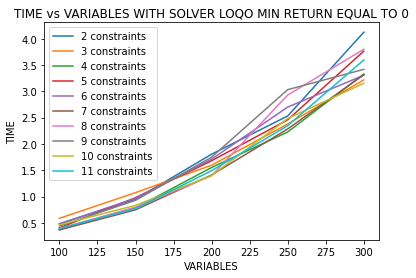

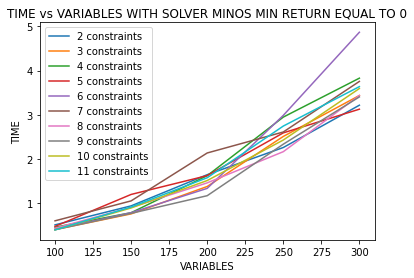

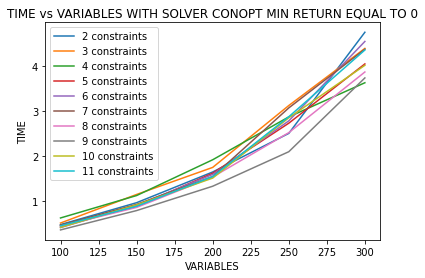

In [18]:
solver_names = ['LOQO', 'MINOS', 'CONOPT']
solver_algs = [loqo, minos, conopt]
for i, solver in enumerate(solver_algs):
    compare_constraints(solver, 'time', 0, solver_names[i])

ValueError: x and y must have same first dimension, but have shapes (7,) and (5,)

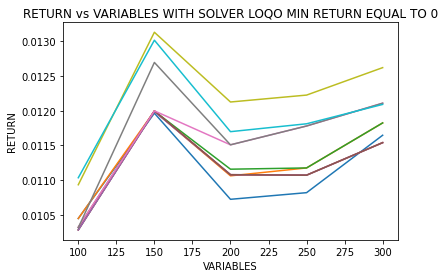

In [19]:
for i, solver in enumerate(solver_algs):
    compare_constraints(solver, 'return', 0, solver_names[i])

In [ ]:
for i, solver in enumerate(solver_algs):
    compare_constraints(solver, 'variance', 0, solver_names[i])

In [ ]:
plt.close('all')

### Varying Solvers

In [ ]:
def compare_solvers(data, constraint, sensitivity):
    fig, ax = plt.subplots()
    legend_names = ['loqo', 'minos', 'conopt']
    solvers = [loqo, minos, conopt]
    for s in solvers:
        x = list(s[sensitivity][data][constraint+2].keys())
        y = list(s[sensitivity][data][constraint+2].values())
        ax.plot(x, y)
    ax.set_title(data.upper() + ' vs VARIABLES FOR ' + str(i+2) + ' CONSTRAINTS' 
                 + ' WITH MIN RETURN EQUAL TO ' + str(sensitivity))
    ax.set_xlabel('VARIABLES')
    ax.set_ylabel(data.upper())
    if data == 'return':
        ax.plot([100, 150, 200, 250, 300, 350, 400], [sensitivity] * len(x))
        legend_names.append('min expected return')
    ax.legend(legend_names)

In [20]:
n = list(range(10))
for i in n:
    compare_solvers('time', i, 0)

NameError: name 'compare_solvers' is not defined

In [21]:
for i in n:
    compare_solvers('return', i, 0)

NameError: name 'compare_solvers' is not defined

In [22]:
for i in n:
    compare_solvers('variance', i, 0)

NameError: name 'compare_solvers' is not defined

In [23]:
plt.close('all') 

# Sensitivity Analysis

### Varying Min Expected Return for Solver and Constraints 

In [24]:
def compare_sensitvity(solver, data, constraint, solver_name):
    s = [0.0, 0.01, 0.02, 0.03, 0.04]
    fig, ax = plt.subplots()
    legend_names = []
    for i in s:
        x = list(solver[i][data][constraint].keys())
        y = list(solver[i][data][constraint].values())
        ax.plot(x, y)
        legend_names.append('min expected return of ' + str(i))
    ax.set_title(data.upper() + ' vs VARIABLES' + ' WITH SOLVER ' 
                 + solver_name + ' CONSTRAINTS ' + str(constraint))
    ax.set_xlabel('VARIABLES')
    ax.set_ylabel(data.upper())
    ax.legend(legend_names)

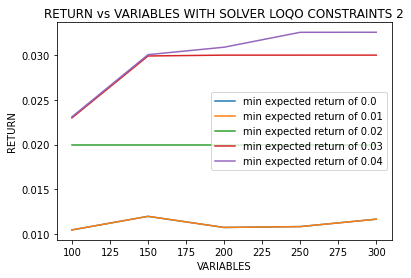

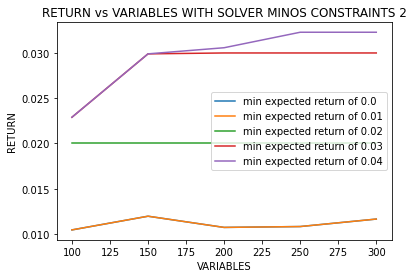

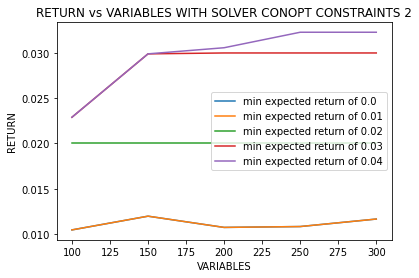

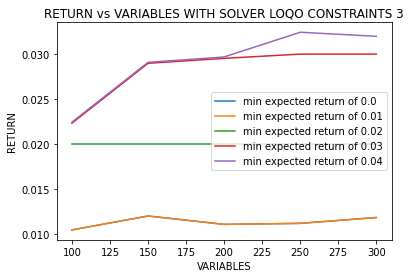

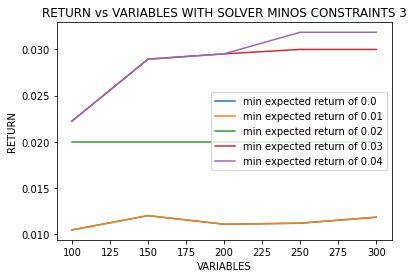

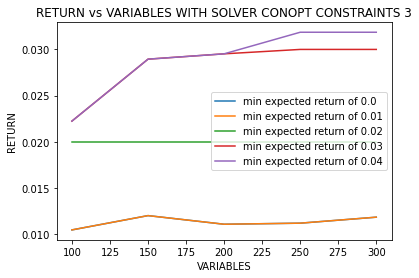

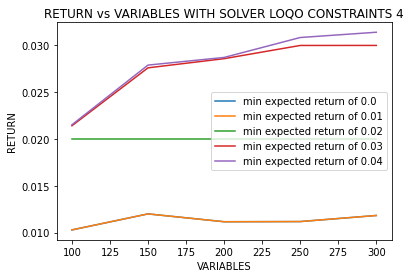

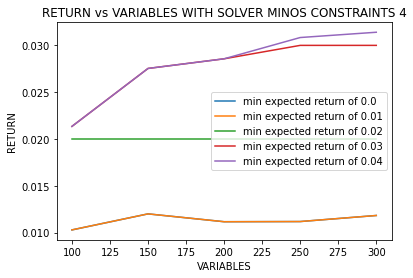

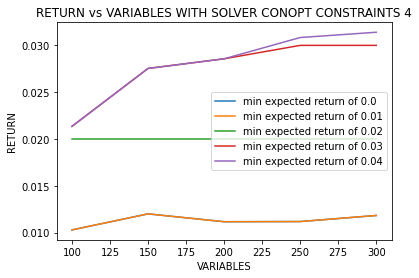

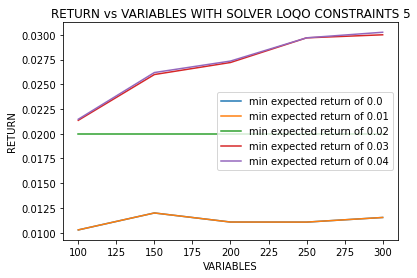

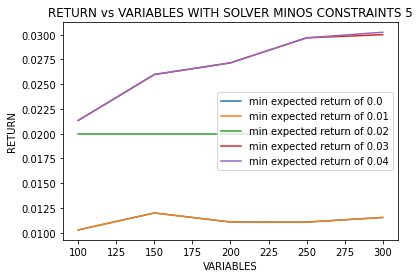

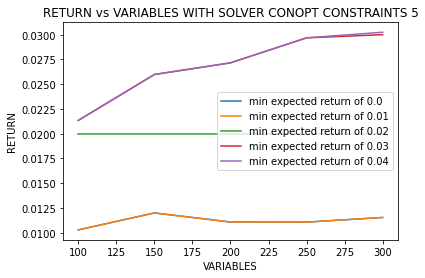

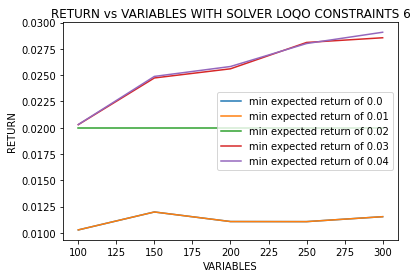

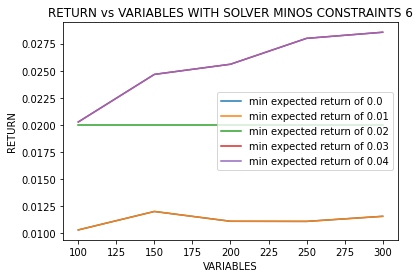

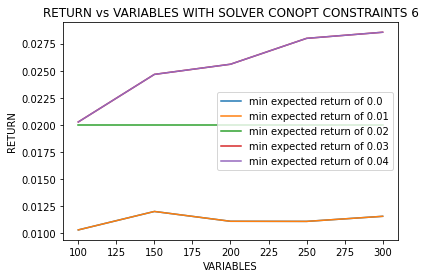

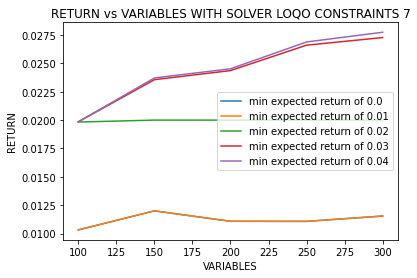

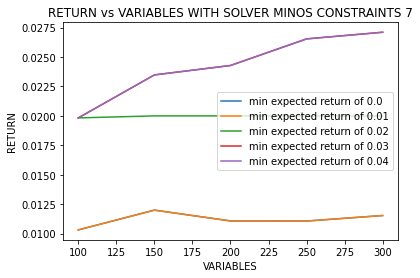

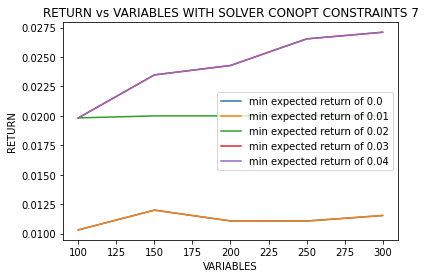

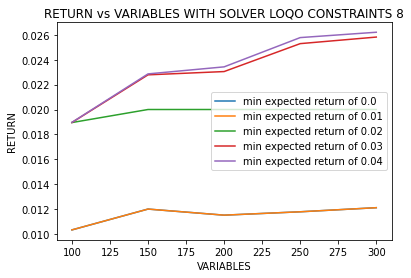

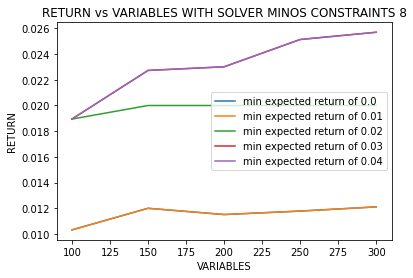

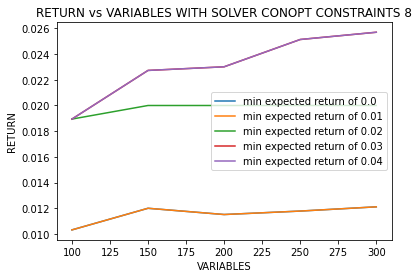

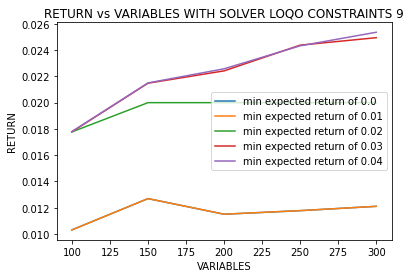

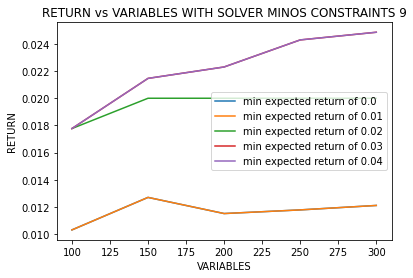

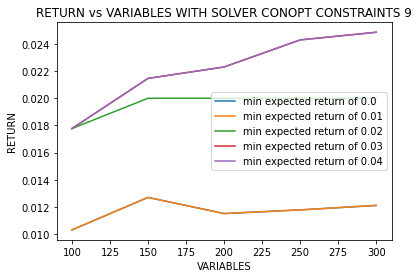

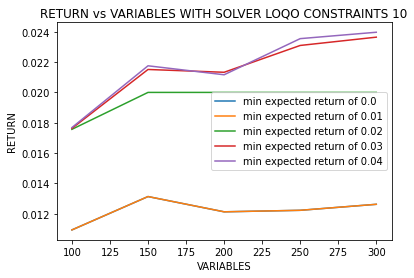

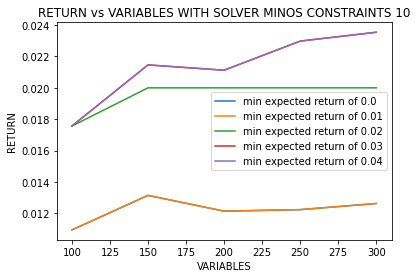

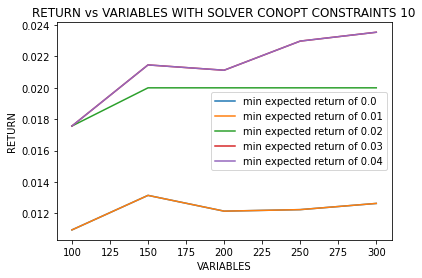

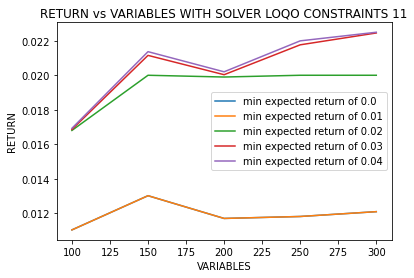

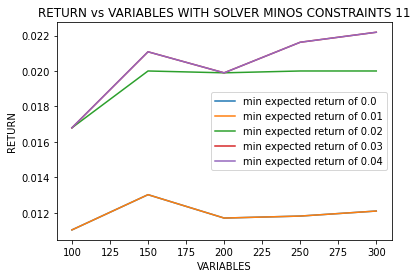

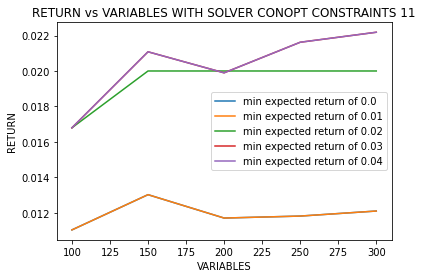

In [25]:
for k in n:
    for i, solver in enumerate(solver_algs):
        compare_sensitvity(solver, 'return', k+2, solver_names[i])

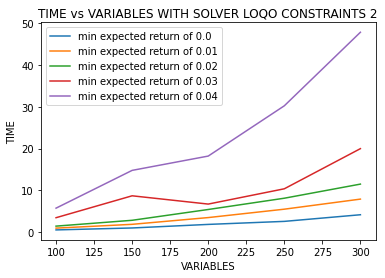

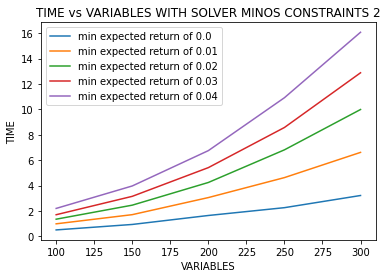

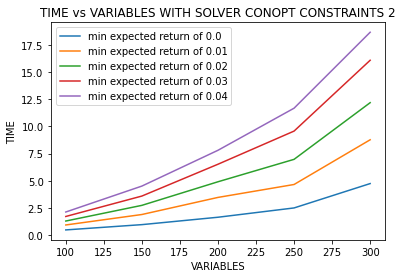

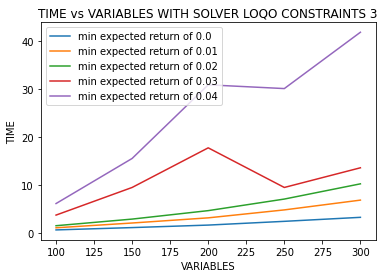

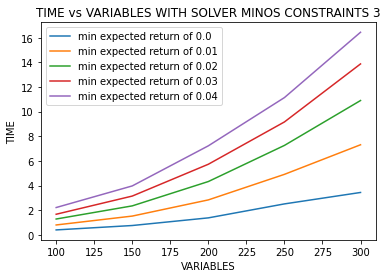

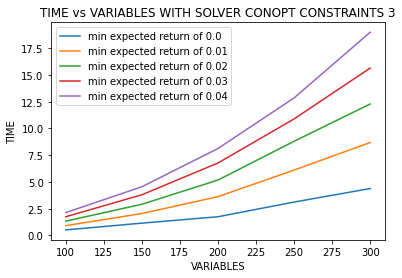

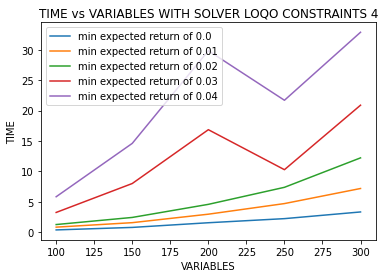

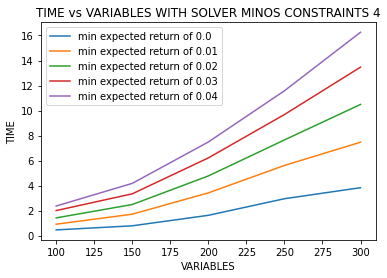

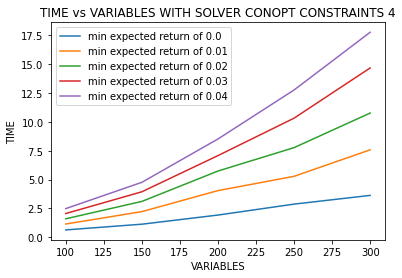

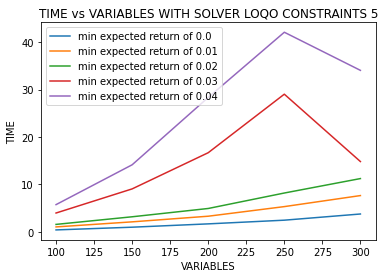

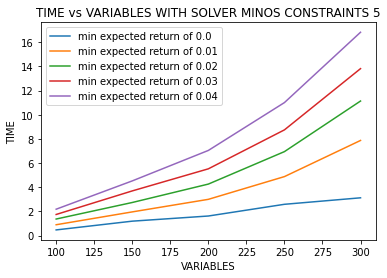

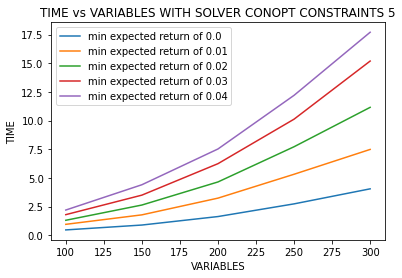

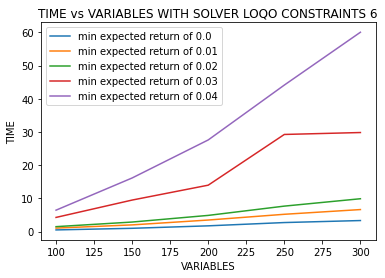

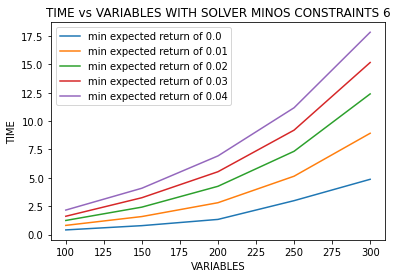

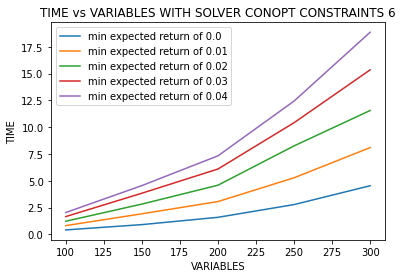

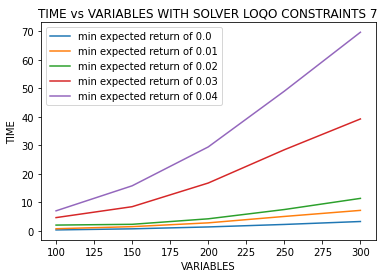

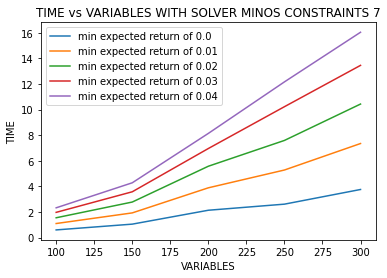

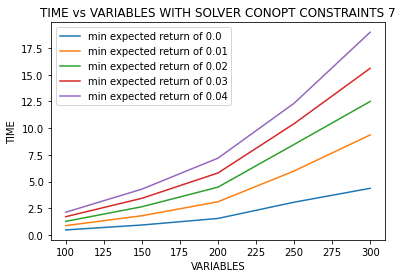

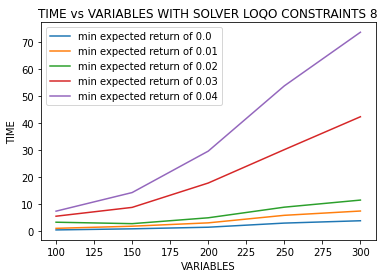

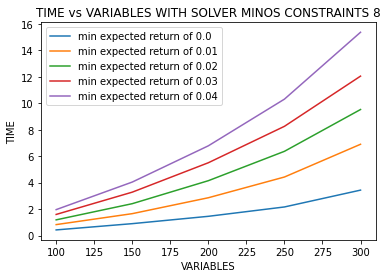

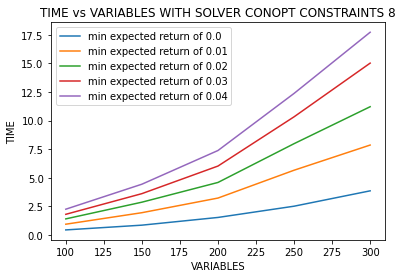

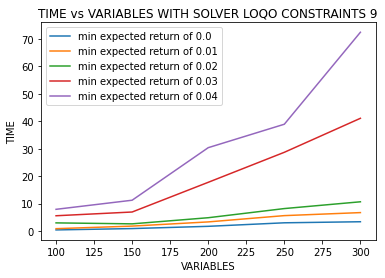

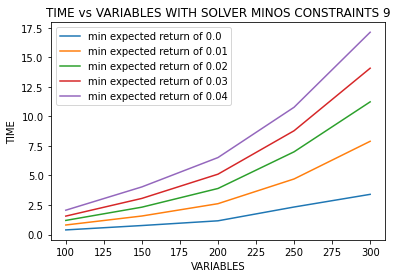

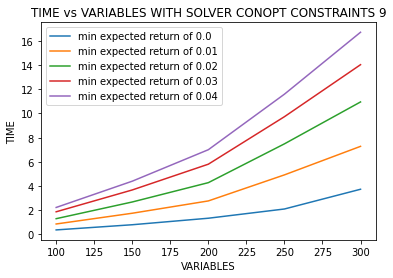

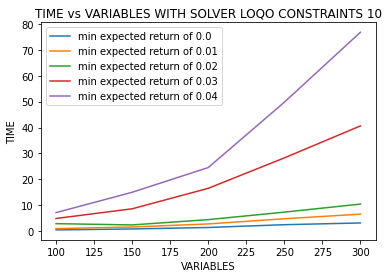

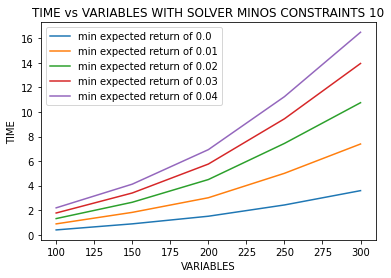

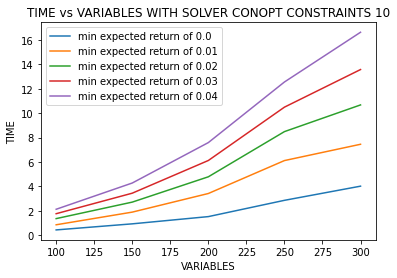

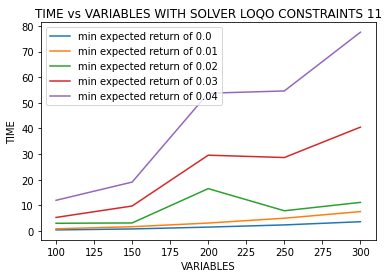

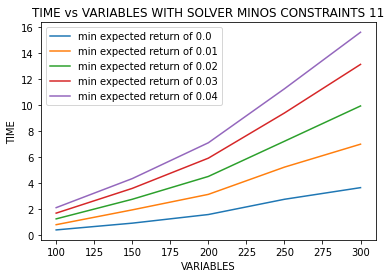

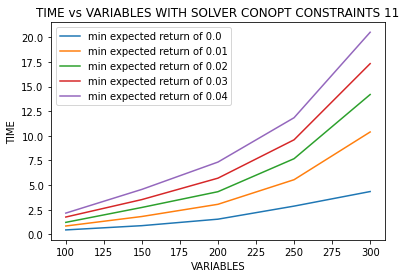

In [26]:
for k in n:
    for i, solver in enumerate(solver_algs):
        compare_sensitvity(solver, 'time', k+2, solver_names[i])

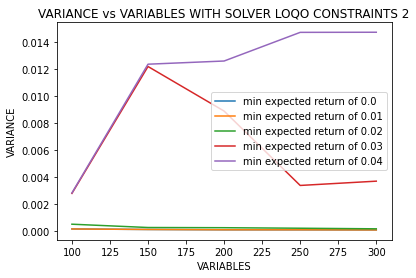

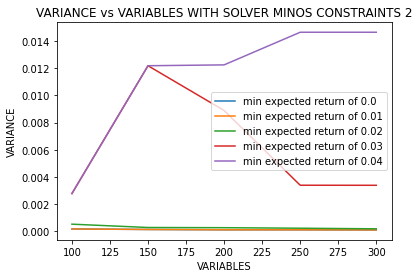

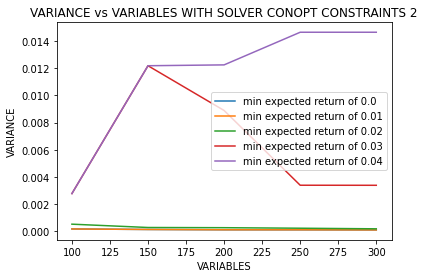

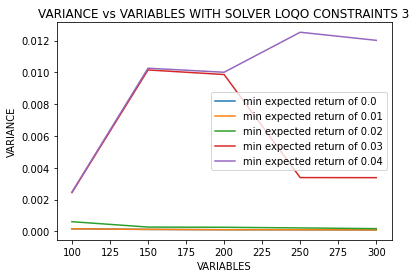

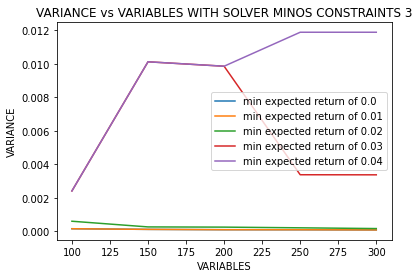

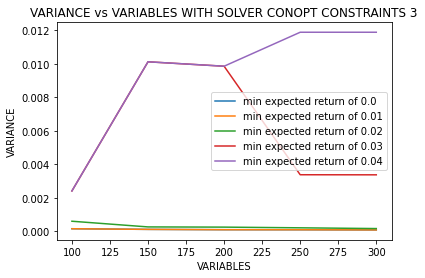

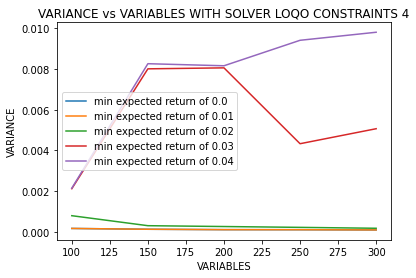

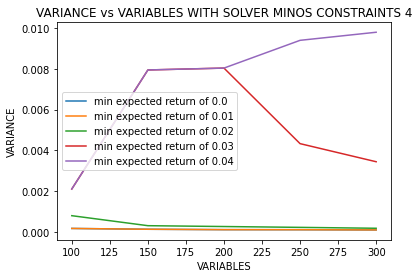

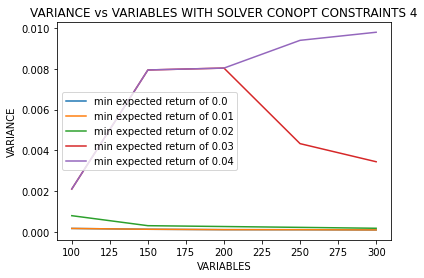

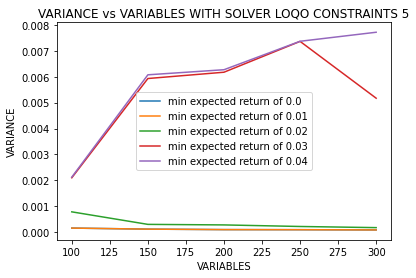

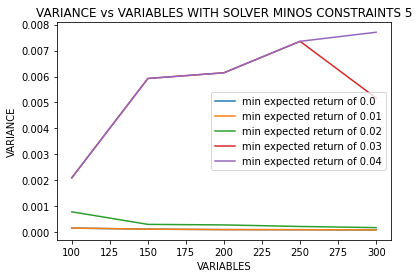

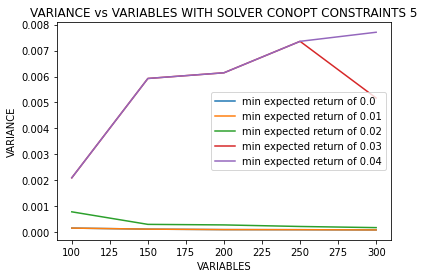

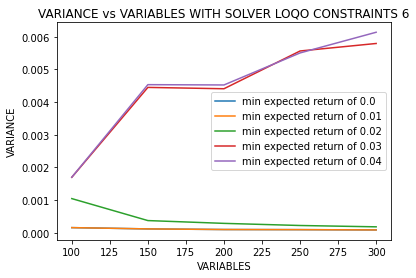

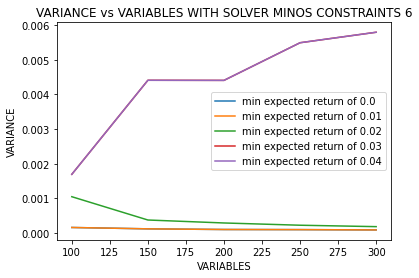

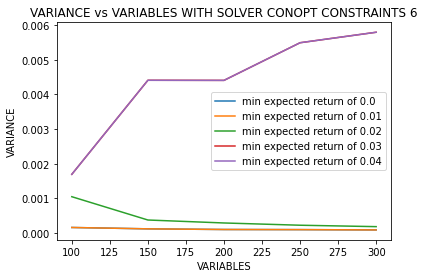

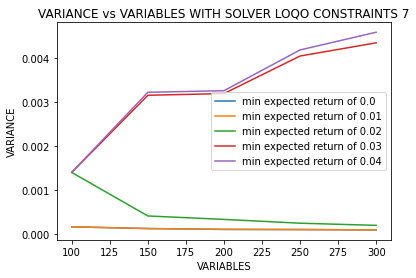

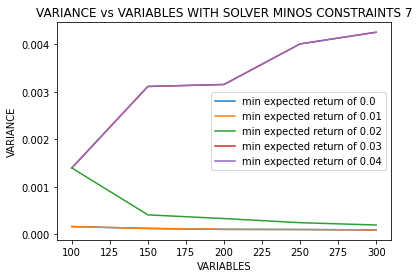

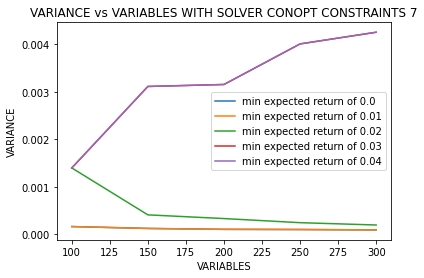

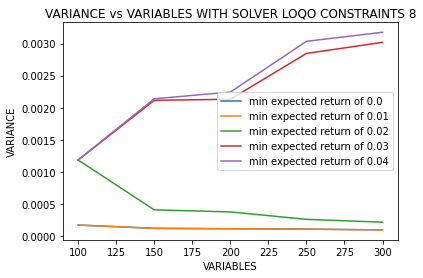

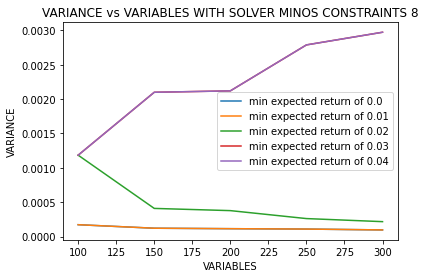

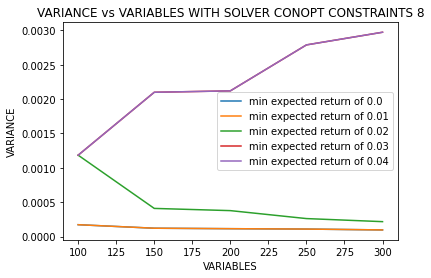

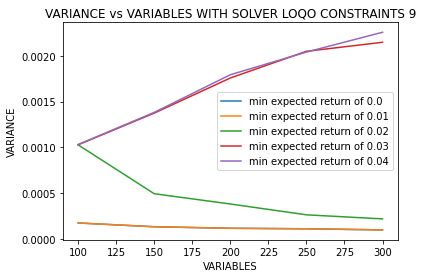

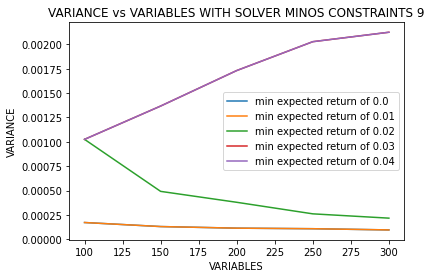

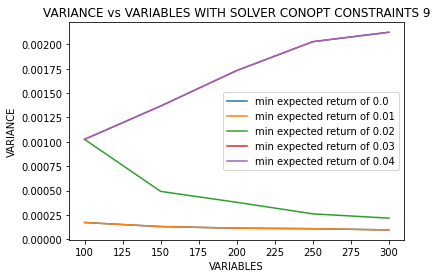

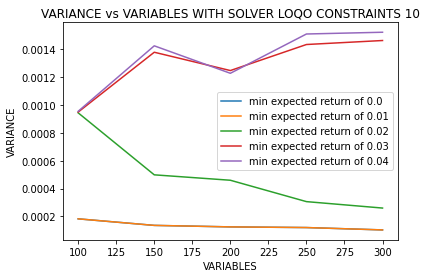

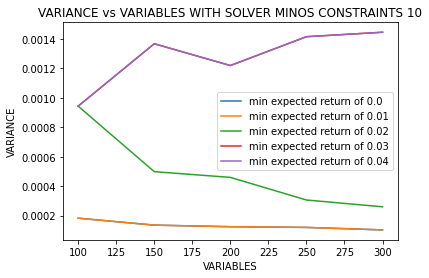

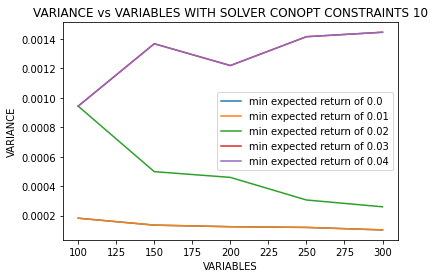

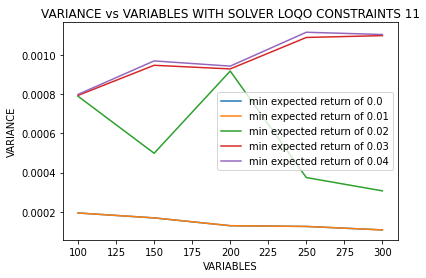

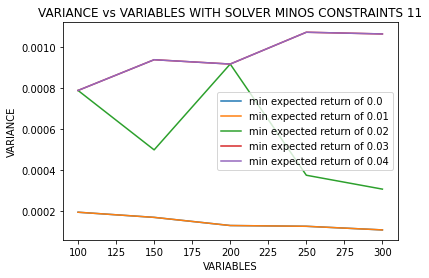

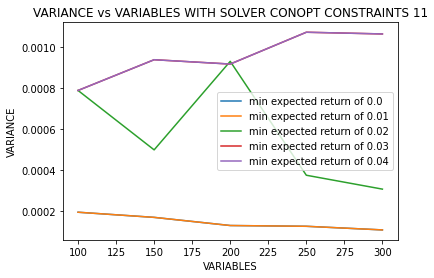

In [27]:
for k in n:
    for i, solver in enumerate(solver_algs):
        compare_sensitvity(solver, 'variance', k+2, solver_names[i])

In [28]:
plt.close('all')

### Varying Constriants for Solver and Expected Return

ValueError: x and y must have same first dimension, but have shapes (7,) and (5,)

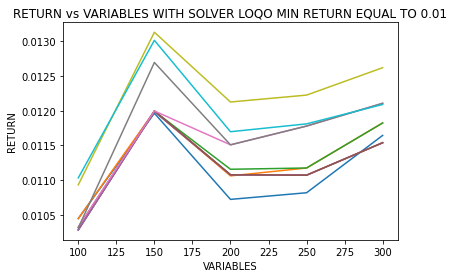

In [29]:
min_returns = [0.01, 0.02, 0.03, 0.04]
for r in min_returns:
    for i, solver in enumerate(solver_algs):
        compare_constraints(solver, 'return', r, solver_names[i])

In [ ]:
for r in min_returns:
    for i, solver in enumerate(solver_algs):
        compare_constraints(solver, 'time', r, solver_names[i])

In [ ]:
for r in min_returns:
    for i, solver in enumerate(solver_algs):
        compare_constraints(solver, 'variance', r, solver_names[i])

In [ ]:
plt.close('all')

### Varying Solver for Constraints and Expected Return

In [ ]:
for r in min_returns:
    for i in n:
        compare_solvers('return', i, r)

In [ ]:
for r in min_returns:
    for i in n:
        compare_solvers('time', i, r)

In [ ]:
for r in min_returns:
    for i in n:
        compare_solvers('variance', i, r)

** **Note: minos and conopt are overlapping above** **

In [30]:
plt.close('all')

# Tables & Heatmaps

In [53]:
def create_table(data, solver):
    transform_one = {}
    for min_return, outcome in solver.items():
        points = {}
        for constraint, variables in outcome[data].items():
            last_key = 0
            for variable, value in variables.items():
                data_value = points.get(variable)
                if data_value is None:
                    points.update({variable: [value]})
                else:
                    data_value.append(value)
                    points.update({variable: data_value})
        transform_one[min_return] = points
    transform_two = {}
    for min_return, outcome in transform_one.items():
        for variables, values in outcome.items():
            transform_two[(min_return, variables)] = values
    df = pd.DataFrame(transform_two).T
    df.columns = df.columns + 2
    return df
    

In [54]:
from IPython.display import set_matplotlib_formats

In [55]:
set_matplotlib_formats('pdf')
def create_heatmap(data, title):
    minos_table = create_table(data, minos)
    minos_table.columns = pd.MultiIndex.from_product([["minos"], minos_table.columns])
    conopt_table = create_table(data, conopt)
    conopt_table.columns = pd.MultiIndex.from_product([["conopt"], conopt_table.columns])
    loqo_table = create_table(data, loqo)
    loqo_table.columns = pd.MultiIndex.from_product([["loqo"], loqo_table.columns])
    all_solvers = pd.concat([loqo_table, conopt_table, minos_table],axis=1)
    fig, ax = plt.subplots(figsize=(30,20))
    plt.rcParams['figure.max_open_warning'] = False
    plt.rcParams['axes.labelsize'] = 16
    plt.rcParams['axes.titlesize'] = 16
    plt.rcParams['xtick.labelsize']= 16
    plt.rcParams['ytick.labelsize'] = 16
    plt.rcParams['legend.fontsize'] = 16 #plt.rcParams['figure.figsize'] = [20, x]
    #plt.rcParams['figure.dpi'] = 1500 #plt.rcParams['figure.figsize'] = [20, x]
    time_output = sns.heatmap(all_solvers, annot=True, annot_kws={"fontsize":10})
    time_output.set(xlabel='Solver - Constraints', 
                    ylabel='Min Expected Return - Variables', 
                    title=title)
    #plt.savefig(title+'.svg')
    return minos_table, conopt_table, loqo_table

In [50]:
def create_heatmap(data, title):
    minos_table = create_table(data, minos)
    minos_table.columns = pd.MultiIndex.from_product([["minos"], minos_table.columns])
    conopt_table = create_table(data, conopt)
    conopt_table.columns = pd.MultiIndex.from_product([["conopt"], conopt_table.columns])
    loqo_table = create_table(data, loqo)
    loqo_table.columns = pd.MultiIndex.from_product([["loqo"], loqo_table.columns])
    all_solvers = pd.concat([loqo_table, conopt_table, minos_table],axis=1)
    fig, ax = plt.subplots(figsize=(30,20))
    time_output = sns.heatmap(all_solvers, annot=True)
    time_output.set(xlabel='Min Expected Return - Variables', 
                    ylabel='Solver - Constraints', 
                    title=title)
    return minos_table, conopt_table, loqo_table

In [46]:
minos_t, conopt_t, loqo_t = create_heatmap('time', 'Time Comparison in Seconds')

<Figure size 2160x1440 with 2 Axes>

In [56]:
minos_r, conopt_r, loqo_r = create_heatmap('return', 'Expected Return Comparison')

<Figure size 2160x1440 with 2 Axes>

In [57]:
minos_v, conopt_v, loqo_v = create_heatmap('variance', 'Variance Comparison')

<Figure size 2160x1440 with 2 Axes>

# Correlation & Covariance Analysis

In [ ]:
def analyze_covariance():
    var = [100, 150, 200, 250, 300, 350, 400]
    result = dict()
    for v in var:
        for k, value in covariances[v].items():
            s1, s2 = k
            result.setdefault(s1, {}).update({s2: value})
        cov = np.array(pd.DataFrame(result))
        det = np.linalg.det(cov)
        if cov.shape[0] == cov.shape[1] and np.linalg.matrix_rank(cov) == cov.shape[0]:
            print('Matrix with ' + str(v) + ' variables is invertible')
        else:
            print('Matrix with ' + str(v) + ' variables is not invertible')
            
def analyze_correlations(v):
    corr = pd.DataFrame(correlations[v])
    fig, ax = plt.subplots(figsize=(30,20))
    output = sns.heatmap(corr)
    output.set(xlabel='Stocks', 
                    ylabel='Stocks', 
                    title='Correlation Among Stocks')

In [ ]:
analyze_covariance()

In [ ]:
analyze_correlations(100)

In [ ]:
analyze_correlations(200)

In [ ]:
plt.close('all')